In [1]:
import torch
from tqdm.autonotebook import tqdm
import pandas as pd
from pathlib import Path
import os

from datetime import date
import numpy as np

from utils import SliceDataset

import matplotlib.pyplot as plt
import sys
import os
sys.path.append(os.path.abspath('/root/data_filtering_mri'))  # Adjust this to the actual path

# from src.data_filt_setups.HeuristicFiltering.HighFrequencyFiltering import HighFrequencyFiltering
from src.data_filt_setups.data_filt_setups import list_data_filtering_setups_str, get_data_filtering_setup

print("Available Filtering Setups:")
print(list_data_filtering_setups_str())

/tmp/ipykernel_1415294/2596395964.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


Available Filtering Setups:
EnergyFiltering
HighFrequencyFiltering
LaplacianBlurDetection
SobelFlatRegionDetection
EdgeSparsityDetection
RandomPickDetection


In [7]:
from src.data_filt_setups.data_filt_setups import list_data_filtering_setups_str, get_data_filtering_setup
# dataset_path = '/root/data_filtering_mri/datasets/train/data_pool_random_volume_subset.json'
# dataset_path = '/root/data_filtering_mri/datasets/train/data_pool_random_volume_subset_EnergyFiltering_threshold_0.1.json'
dataset_path = '/root/data_filtering_mri/datasets/evals/classic/nuanced/cmrxrecon2023_curated_lax.json'
# Change the name of the method:
filtering_setup = get_data_filtering_setup('RandomPickDetection', file_path=dataset_path, is_debug=True)
filtered_samples,metric_record = filtering_setup.filter()

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '/media/ssd0/cmrxrecon2023/converted/val/val_P035_cine_lax_t=7.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

(array([3193., 2331., 1223.,  727.,  464.,  887.,  686.,  352.,   78.,
          59.]),
 array([0.        , 0.0144751 , 0.0289502 , 0.04342529, 0.05790039,
        0.07237549, 0.08685059, 0.10132568, 0.11580078, 0.13027588,
        0.14475098]),
 <BarContainer object of 10 artists>)

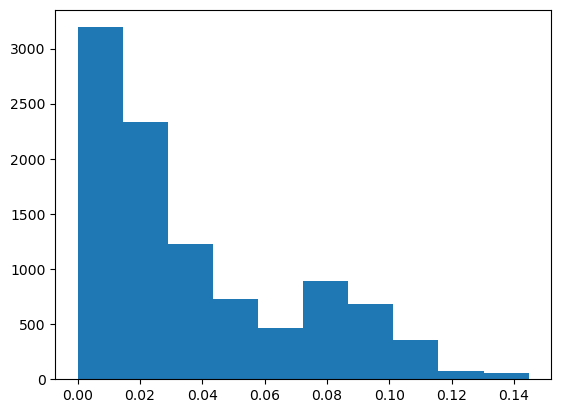

In [4]:
plt.hist(np.array(metric_record))

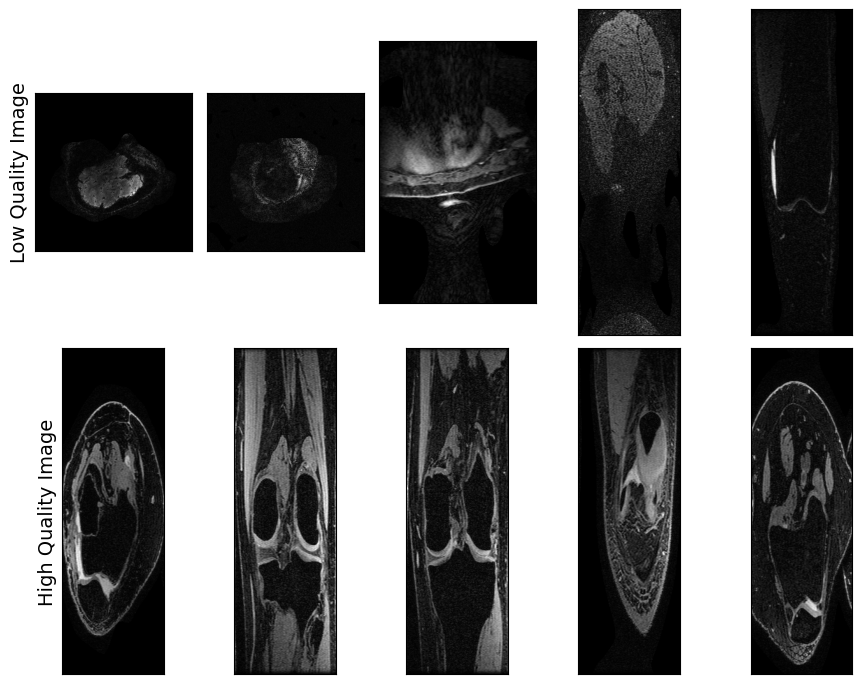

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Decide the threshold for observing the data
# Example for Edge Detection
threshold = 0.03  # You can change this based on the metric you're using
Nc = 5
def visualize_images_by_threshold(low_images, high_images, threshold, columns=5):
    """
    Visualize images split by threshold in a 2-row layout.
    
    * low_images: List of images with metric below the threshold.
    * high_images: List of images with metric above the threshold.
    * threshold: The threshold used to separate the images.
    * columns: The number of columns for the subplot layout.
    """
    num_low = len(low_images)
    num_high = len(high_images)
    
    # Define the number of rows and columns
    rows = 2
    total_cols = max(num_low, num_high, columns)  # At least as many columns as there are images, but limited by columns arg
    
    # Create the subplot figure with 2 rows
    fig, axes = plt.subplots(rows, total_cols, figsize=(9, 8))
    
    # Plot the first row (low images)
    for i in range(total_cols):
        if i < num_low:
            axes[0, i].imshow(np.abs(low_images[i]), cmap='gray')
            # axes[0, i].set_title(f"Low Edge ({i+1})")
            axes[0, i].set_xticks([])  # Remove x-ticks
            axes[0, i].set_yticks([])  # Remove y-ticks
        else:
            axes[0, i].axis('off')  # Turn off unused subplots
            
    # Plot the second row (high images)
    for i in range(total_cols):
        if i < num_high:
            axes[1, i].imshow(np.abs(high_images[i]), cmap='gray')
            # axes[1, i].set_title(f"High Edge ({i+1})")
            axes[1, i].set_xticks([])  # Remove x-ticks
            axes[1, i].set_yticks([])  # Remove y-ticks
        else:
            axes[1, i].axis('off')  # Turn off unused subplots
    axes[0, 0].set_ylabel("Low Quality Image", fontsize=14)
    axes[1, 0].set_ylabel("High Quality Image", fontsize=14)
    # Adjust layout for better fit
    # plt.suptitle(f"Images Split by Edge Density Threshold: {threshold}", fontsize=16)
    plt.tight_layout()
    plt.subplots_adjust(top=0.85)
    plt.show()

# Split dataset by threshold into low and high metric groups
low_metric_indices = [i for i, metric in enumerate(metric_record) if metric < (threshold-0.01)]
high_metric_indices = [i for i, metric in enumerate(metric_record) if metric >= (threshold+0.01)]
# Randomly select Nc samples from each group (ensure we don't exceed available samples)
low_metric_samples = random.sample(low_metric_indices, min(Nc, len(low_metric_indices)))
high_metric_samples = random.sample(high_metric_indices, min(Nc, len(high_metric_indices)))

# Collect the actual images from the dataset using the selected indices
low_metric_images = [filtering_setup.dataset[i][1] for i in low_metric_samples]  # Image data is at index 1
high_metric_images = [filtering_setup.dataset[i][1] for i in high_metric_samples]  # Image data is at index 1

# Visualize the images in a 2-row layout with user-defined columns (e.g., 5 columns)
visualize_images_by_threshold(low_metric_images, high_metric_images, threshold, columns=Nc)

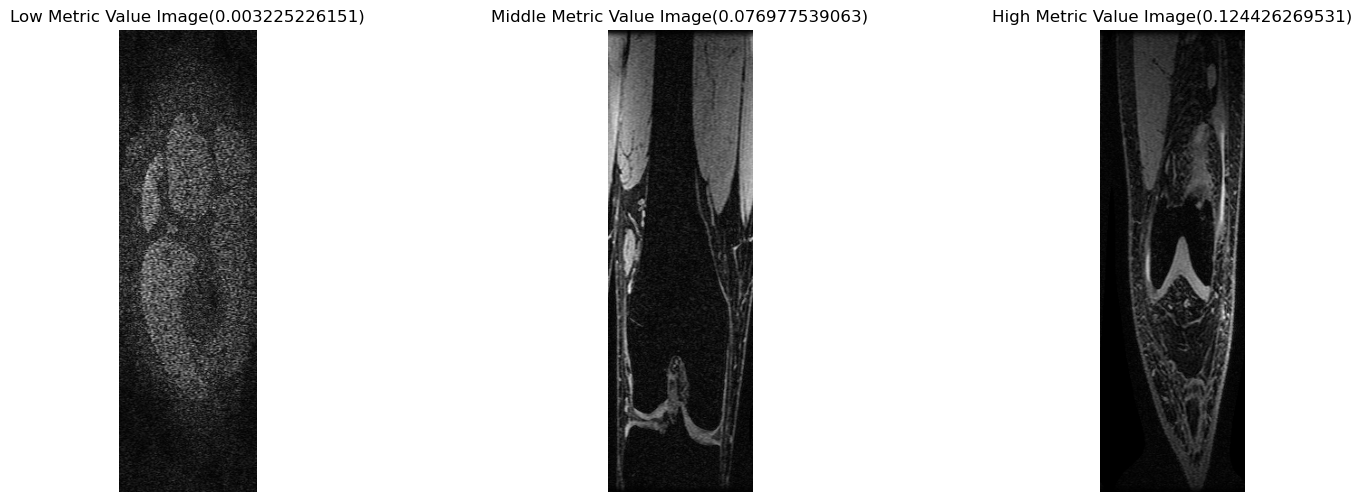

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import random

# Decide the threshold for observing the data
# High Frequency Filtering
# lower_threshold = 0.2
# upper_threshold = 0.5 # Useful Threshold

# Blur Detection
# lower_threshold = 0.5
# upper_threshold = 1.5 # Useful Threshold

# Flat Detection:
# lower_threshold = 0.015 # Useful Threshold
# upper_threshold = 0.07 

# Edge Detection:
lower_threshold = 0.03 # Useful Threshold
upper_threshold = 0.12 


def visualize_three_images(image1, image2, image3, title1="Low", title2="Middle", title3="High"):

    # Perform inverse FFT to reconstruct the images (if necessary)
    image1 = np.abs(image1)
    image2 = np.abs(image2)
    image3 = np.abs(image3)
    
    # Create figure with three subplots
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Display first image (low)
    axes[0].imshow(image1, cmap='gray')
    axes[0].set_title(title1)
    axes[0].axis('off')

    # Display second image (middle)
    axes[1].imshow(image2, cmap='gray')
    axes[1].set_title(title2)
    axes[1].axis('off')

    # Display third image (high)
    axes[2].imshow(image3, cmap='gray')
    axes[2].set_title(title3)
    axes[2].axis('off')

    # Show the figure
    plt.show()

low_metric_indices = [i for i, metric in enumerate(metric_record) if metric < lower_threshold]
middle_metric_indices = [i for i, metric in enumerate(metric_record) if lower_threshold <= metric < upper_threshold]
high_metric_indices = [i for i, metric in enumerate(metric_record) if metric >= upper_threshold]

low_metric_sample_idx = random.choice(low_metric_indices)
middle_metric_sample_idx = random.choice(middle_metric_indices)
high_metric_sample_idx = random.choice(high_metric_indices)

low_metric_sample = filtering_setup.dataset[low_metric_sample_idx]
middle_metric_sample = filtering_setup.dataset[middle_metric_sample_idx]
high_metric_sample = filtering_setup.dataset[high_metric_sample_idx]

target_low = low_metric_sample[1]
target_middle = middle_metric_sample[1]
target_high = high_metric_sample[1]

visualize_three_images(
    target_low, target_middle, target_high, 
    title1=f"Low Metric Value Image({metric_record[low_metric_sample_idx]:.12f})", 
    title2=f"Middle Metric Value Image({metric_record[middle_metric_sample_idx]:.12f})", 
    title3=f"High Metric Value Image({metric_record[high_metric_sample_idx]:.12f})"
)
